# Create Grid to Neighbor Mapping

In [1]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import descartes
import sys
import sklearn
import math
from datetime import datetime as dt
sys.path.append('C:\\Users\\jades\\1001 Intro to Data Science Notebooks\\Project\\wildfires-1001\\code\\functions')
from gis_processing import *

import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
gitdir = 'C:/Users/jades/1001 Intro to Data Science Notebooks/Project/wildfires-1001/'

In [5]:
#Import grid data
subdir_from = 'data/clean_data/county_grid/'
filename_from = 'county_grid.shp'

county_grid_map = gpd.read_file(gitdir + subdir_from + filename_from)

county_grid_map = county_grid_map.to_crs(crs='epsg:4326')

In [4]:
county_grid_map

,NAME,COUNTYFP,GEOID,ALAND,AWATER,COUNTY_ARE,GRID_AREA,GRID_ID,COUNTY_GRI,COUNTY_G_1,geometry
0,Plumas,063,06063,6612400993,156387635,1.155000e+10,5.041000e+09,49.0,4.936293e+09,0.427385,"POLYGON ((-121.29300 40.21977, -120.65520 40.2..."
1,Sierra,091,06091,2468694587,23299110,4.200450e+09,5.041000e+09,50.0,1.535563e+09,0.365571,"POLYGON ((-121.29300 39.73101, -120.65520 39.7..."
2,Sierra,091,06091,2468694587,23299110,4.200450e+09,5.041000e+09,65.0,2.544187e+09,0.605694,"POLYGON ((-120.65520 39.73101, -120.01739 39.7..."
3,Sacramento,067,06067,2499183617,76073827,4.205267e+09,5.041000e+09,39.0,2.029400e+09,0.482585,"POLYGON ((-121.93080 38.74303, -121.29300 38.7..."
4,Contra Costa,013,06013,1871930816,209819213,3.351027e+09,5.041000e+09,40.0,1.618024e+09,0.482844,"POLYGON ((-121.93080 38.24384, -121.29300 38.2..."
5,Amador,005,06005,1539933576,29470568,2.562528e+09,5.041000e+09,52.0,1.528036e+09,0.596300,"POLYGON ((-121.29300 38.74303, -120.65520 38.7..."
6,San Joaquin,077,06077,3606276598,89025932,5.950289e+09,5.041000e+09,53.0,2.780347e+09,0.467263,"POLYGON ((-121.29300 38.24384, -120.65520 38.2..."
7,San Luis Obispo,079,06079,8548640337,815490673,1.412072e+10,4.974228e+08,59.0,2.704664e+08,0.019154,"POLYGON ((-120.68214 34.65378, -120.67791 34.6..."
8,Santa Barbara,083,06083,7084000598,2729814515,1.449841e+10,5.041000e+09,74.0,3.443717e+09,0.237524,"POLYGON ((-120.65520 35.17677, -120.01739 35.1..."
9,Santa Barbara,083,06083,7084000598,2729814515,1.449841e+10,2.258177e+09,75.0,2.258125e+09,0.155750,"MULTIPOLYGON (((-120.01739 34.40575, -120.0189..."


In [4]:

county_grid_map['key'] = 1
county_grid_map['centroid'] = county_grid_map.centroid
county_grid_map['lat'] = county_grid_map.centroid.y
county_grid_map['long'] = county_grid_map.centroid.x

county_grid_map_cross = county_grid_map.merge(county_grid_map, how='outer', on='key')

county_grid_map_cross['distance'] = ((county_grid_map_cross['lat_x']-county_grid_map_cross['lat_y'])**2 + (county_grid_map_cross['long_x']-county_grid_map_cross['long_y'])**2)**(1/2)

In [5]:
#Create the mapping of each grid ID (GRID_ID_x) to its neighbors (GRID_ID_y)
distance_thresh = 0.85 #Through iteration, this was the distance that captures the 8 surrounding grids

neighbor_map = county_grid_map_cross[(county_grid_map_cross['distance'] > 0) & (county_grid_map_cross['distance'] < distance_thresh)][['GRID_ID_x', 'GRID_ID_y', 'distance']]

In [6]:
#Create feature for the count of nearby grids and a multiplier that is 8 over the count (to normalize edge grids)
nearby_count = neighbor_map.groupby(neighbor_map['GRID_ID_x']).count()['GRID_ID_y']

neighbor_map = neighbor_map.merge(nearby_count, how='left', on='GRID_ID_x')

neighbor_map['multiplier'] = 8/neighbor_map['GRID_ID_y_y']

neighbor_map = neighbor_map.drop(['distance', 'GRID_ID_y_y'], axis=1)
neighbor_map = neighbor_map.rename(columns={"GRID_ID_x": "GRID_ID", "GRID_ID_y_x": "GRID_ID_adj"})

In [7]:
#Save the mapping df
subdir_to = 'data/clean_data/mapping_tables/'
filename_to = 'grid_neighbor_map.csv'
neighbor_map.to_csv(gitdir + subdir_to + filename_to, index=False)

## Visualize/Validate

In [8]:
#Visualize nearest neighbors (1/2)
grid = 59 #Input the grid value you want to check

county_grid_map_cross[(county_grid_map_cross['distance'] > 0) & (county_grid_map_cross['distance'] < 0.85) & (county_grid_map_cross['GRID_ID_x'] == grid)][['GRID_ID_x', 'GRID_ID_y', 'distance']]

,GRID_ID_x,GRID_ID_y,distance
946,59.0,74.0,0.383656
947,59.0,75.0,0.612243
1057,59.0,73.0,0.575198
1071,59.0,58.0,0.515047


<AxesSubplot:>

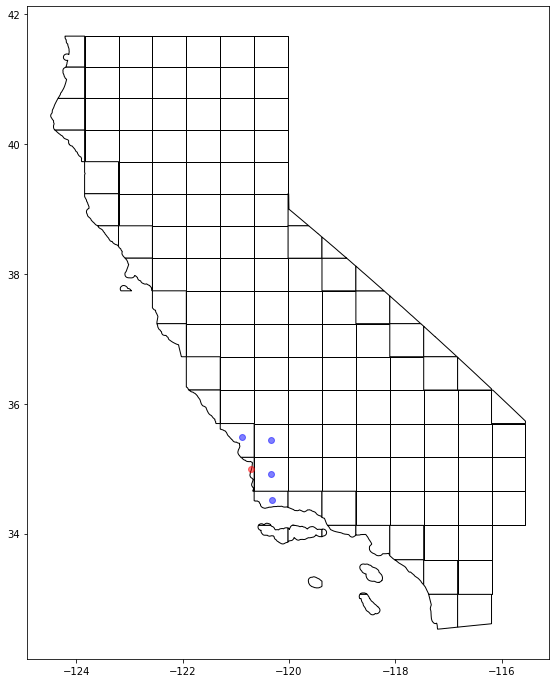

In [9]:
#Plot (2/2)
neighbors = [74,75,73,58] #Copy the GRID_ID_y values above into this list and plot

ax = county_grid_map.plot(color = 'white', edgecolor = 'black', figsize = (12,12))
county_grid_map[county_grid_map['GRID_ID'].isin([grid])]['centroid'].plot(ax=ax, color = 'red', alpha = 0.5, figsize = (12,12))
county_grid_map[county_grid_map['GRID_ID'].isin(neighbors)]['centroid'].plot(ax=ax, color = 'blue', alpha = 0.5, figsize = (12,12))